###Install Packages

In [ ]:
import numpy as np
!pip install scikit-learn==1.3.0
import os
import matplotlib.pyplot as plt
from pathlib import *
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
!pip install tensorflow-addons --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 67.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.0 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.3.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This b

###Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


###Constants

In [ ]:
# DIRECTORIES

CURRENT_PATH = "/content/drive/My Drive/max_sinus6"
# DATASET_PATH = "dataset"
DATASET_PATH = "/content/drive/My Drive/max_sinus6"
DATASET_TRAIN = "train"
DATASET_VAL = "val"
DATASET_TEST = "test"

# Directory structure for Train, Validation and Test dataset
DIR_NAMES = {
    "clear": "clear",
    "opaque": "opaque",
    "thick": "thick"
}

# Number of Classes
NUM_CLASSES = 3
# Classes
CLASSES = {
    "clear":0,
    "opaque":1,
    "thick":2
}

BALANCE_DATASET = False

# IMAGE CONFIG
CHANNELS = 3
IMG_SIZE = (200, 200)
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[0], CHANNELS)

# HYPER PARAMETERS (MLP)
BATCH_SIZE = 32
NUM_EPOCHS = 150
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

PATCH_SIZE = 10
NUM_PATCHES = (IMG_SIZE[0] // PATCH_SIZE) ** 2

# MLP_HEAD_UNITS = [2048, 1024]
EMBEDDING_DIM = 256
NUM_BLOCKS = 4
DROPOUT_RATE = 0.1

###Paths

In [ ]:
TRAIN_PATHS = list()
VAL_PATHS = list()
TEST_PATHS = list()
PATHS_CLASS = list()

In [ ]:
for class_name, name in DIR_NAMES.items():
    TRAIN_PATHS.append(os.path.join(CURRENT_PATH, DATASET_PATH, DATASET_TRAIN, name))
    VAL_PATHS.append(os.path.join(CURRENT_PATH, DATASET_PATH, DATASET_VAL, name))
    TEST_PATHS.append(os.path.join(CURRENT_PATH, DATASET_PATH, DATASET_TEST, name))
    PATHS_CLASS.append(class_name)

###Array of filenames along with absolute path

In [ ]:
# train dataset
x_train_temp = list()
x_train = list()
y_train = list()

# validation dataset
x_val_temp = list()
x_val = list()
y_val = list()

# test dataset
x_test_temp = list()
x_test = list()
y_test = list()

In [ ]:
for class_name, name in DIR_NAMES.items():
    index = PATHS_CLASS.index(class_name)
    class_id = CLASSES[class_name]
    train_filenames = [os.path.join(TRAIN_PATHS[index], filename) for filename in os.listdir(TRAIN_PATHS[index])]
    x_train_temp.append(train_filenames)

    val_filenames = [os.path.join(VAL_PATHS[index], filename) for filename in os.listdir(VAL_PATHS[index])]
    x_val_temp.append(val_filenames)

    test_filenames = [os.path.join(TEST_PATHS[index], filename) for filename in os.listdir(TEST_PATHS[index])]
    x_test_temp.append(test_filenames)

###Image count & classes

In [ ]:
print("CLASS\tTRAIN\tVAL\tTEST")
for i in range(NUM_CLASSES):
    print(f"{PATHS_CLASS[i]}\t{len(x_train_temp[i])}\t{len(x_val_temp[i])}\t{len(x_test_temp[i])}")

CLASS	TRAIN	VAL	TEST
clear	275	55	36
opaque	275	55	36
thick	275	55	36


###Function to map class names to numerical identifiers

In [ ]:
def get_y(class_name):
    return CLASSES[class_name]

In [ ]:
def get_class_from_index(index: int):
    for class_name, value in CLASSES.items():
        if value == index:
            return class_name

In [ ]:
get_class_from_index(0), get_class_from_index(1), get_class_from_index(2)

('clear', 'opaque', 'thick')

###Open one image

In [ ]:
def preprocess_image(filename):
    image_str = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_str, channels=CHANNELS)
    image = tf.image.resize(image, IMG_SIZE)
    return image

In [ ]:
def get_image(filename):
    img = preprocess_image(filename)
    return tf.keras.preprocessing.image.array_to_img(img)

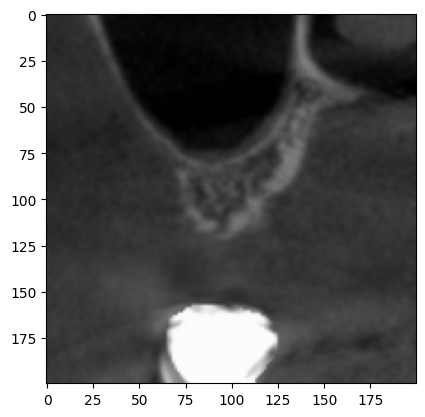

In [ ]:
t_name = x_train_temp[0][1]
img = preprocess_image(t_name)
plt.imshow(tf.keras.preprocessing.image.array_to_img(img))

###Initializing arrays for training, validation, and testing datasets

In [ ]:
# train
x_train = np.array([])
y_train = np.array([])

# val
x_val = np.array([])
y_val = np.array([])

# test
x_test = np.array([])
y_test = np.array([])

###Creating the input and output

In [ ]:
def concat_dataset(arr, dataset, init):
    if init:
        arr = np.array([ preprocess_image(filename) for filename in dataset ])
        arr = arr/255.0
    else:
        temp = np.array( [preprocess_image(filename) for filename in dataset] )
        temp = temp/255.0
        arr = np.concatenate( ( arr,  temp) )
    return arr

In [ ]:
for i in range(len(x_train_temp)):
    class_name = PATHS_CLASS[i]
    y = get_y(class_name)

    # train
    train_total = len(x_train_temp[i])
    print(train_total, y)
    y_train = np.concatenate( ( y_train, np.full((train_total), y) ) )
    x_train = concat_dataset(x_train, x_train_temp[i], i == 0)

    # val
    val_total = len(x_val_temp[i])
    y_val = np.concatenate( ( y_val, np.full((val_total), y) ) )
    x_val = concat_dataset(x_val, x_val_temp[i], i == 0)

    # test
    test_total = len(x_test_temp[i])
    y_test = np.concatenate( ( y_test, np.full((test_total), y) ) )
    x_test = concat_dataset(x_test, x_test_temp[i], i == 0)

275 0
275 1
275 2


In [ ]:
len(x_train), len(x_val), len(x_test)

(825, 165, 108)

###Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(*IMG_SIZE),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation"
)

In [ ]:
data_augmentation.layers[0].adapt(x_train)

In [ ]:
len(x_train_temp[2]), len(x_train[100:]), len(y_train)

(275, 725, 825)

###gMLP Classifier

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding="VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Image size: 200 X 200
Patch size: 10 X 10
Patches per image: 400
Elements per patch: 300


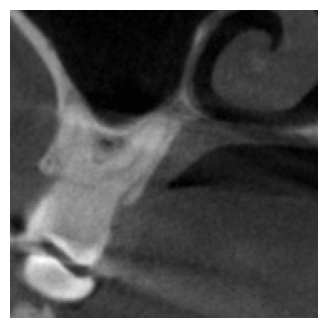

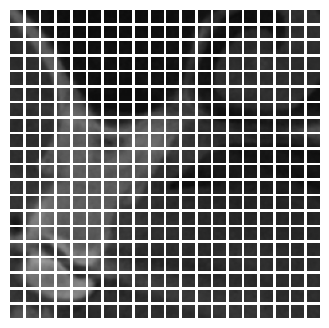

In [ ]:
import matplotlib.pyplot as plt

random_index = np.random.choice(range(len(x_train_temp[0])))
image_file_name = x_train_temp[0][random_index]

plt.figure(figsize=(4, 4))
image = preprocess_image(image_file_name)
plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=IMG_SIZE
)
patches = Patches(PATCH_SIZE)(resized_image)
print(f"Image size: {IMG_SIZE[0]} X {IMG_SIZE[0]}")
print(f"Patch size: {PATCH_SIZE} X {PATCH_SIZE}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (PATCH_SIZE, PATCH_SIZE, CHANNELS))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


In [ ]:
class MLPPatches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches


In [ ]:
def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=INPUT_SHAPE)
    augmented = data_augmentation(inputs)
    patches = MLPPatches(PATCH_SIZE, NUM_PATCHES)(augmented)
    x = layers.Dense(units=EMBEDDING_DIM)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=NUM_PATCHES, delta=1)
        position_embedding = layers.Embedding(
            input_dim=NUM_PATCHES, output_dim=EMBEDDING_DIM
        )(positions)
        x = x + position_embedding

    x = blocks(x)

    representation = layers.GlobalAveragePooling1D()(x)
    representation = layers.Dropout(rate=DROPOUT_RATE)(representation)
    logits = layers.Dense(NUM_CLASSES)(representation)

    return keras.Model(inputs=inputs, outputs=logits)

In [ ]:
def run_experiment_mlp(model, load_model=False):

    optimizer =tf.keras.optimizers.Adam(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
        ],
    )

    history=None
    if load_model==False:
     history = model.fit(
        x=x_boot,
        y=y_boot,
        batch_size=BATCH_SIZE,
        epochs=NUM_EPOCHS,
        validation_data=(x_val, y_val),
      )

    if load_model:
      gmlp_model_weights = '/content/drive/MyDrive/gmlp_model_weights2.h5'
      model.load_weights(gmlp_model_weights)

    return history, model


In [ ]:
class gMLPLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.channel_projection1 = keras.Sequential(
            [
                layers.Dense(units=embedding_dim * 2),
                tf.keras.layers.ReLU(),
                layers.Dropout(rate=dropout_rate),
            ]
        )

        self.channel_projection2 = layers.Dense(units=embedding_dim)

        self.spatial_projection = layers.Dense(
            units=num_patches, bias_initializer="Ones"
        )

        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def spatial_gating_unit(self, x):
        u, v = tf.split(x, num_or_size_splits=2, axis=2)
        v = self.normalize2(v)

        v_channels = tf.linalg.matrix_transpose(v)
        v_projected = self.spatial_projection(v_channels)
        v_projected = tf.linalg.matrix_transpose(v_projected)
        return u * v_projected

    def call(self, inputs):
        x = self.normalize1(inputs)
        x_projected = self.channel_projection1(x)
        x_spatial = self.spatial_gating_unit(x_projected)
        x_projected = self.channel_projection2(x_spatial)
        return x + x_projected

###Load saved gMLP model

In [ ]:
gmlp_model_weights = '/content/drive/MyDrive/gmlp_model_weights2.h5'

###Training

In [ ]:
gmlp_blocks = keras.Sequential(
     [gMLPLayer(NUM_PATCHES, EMBEDDING_DIM, DROPOUT_RATE) for _ in range(NUM_BLOCKS)]
)
learning_rate = 0.001
gmlp_model = build_classifier(gmlp_blocks)
history, gmlp_model = run_experiment_mlp(gmlp_model, True)

###Model Summary

In [ ]:
gmlp_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 200, 200, 3)         │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mlp_patches (MLPPatches)             │ (None, 400, 300)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 400, 256)            │          77,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 400, 256)            │       1,435,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,513,034 (5.77 MB)

 Trainable params: 1,513,027 (5.77 MB)

 Non-trainable params: 7 (32.00 B)

###Uncertainty Estimation

In [ ]:
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from scipy.special import softmax

import matplotlib.cm as cm

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from scipy.stats import entropy
from tensorflow.image import resize

###Section 1

###1. Calculation of mean and variance

In [ ]:
class_labels = ['clear', 'opaque', 'thick']
def predict_with_uncertainty(model, x, n_iter=100):

    predictions = np.zeros((n_iter, x.shape[0], NUM_CLASSES))

    for i in range(n_iter):
        predictions[i] = model(x, training=True).numpy()

    prediction_mean = np.mean(predictions, axis=0)
    prediction_variance = np.var(predictions, axis=0)

    return prediction_mean, prediction_variance

In [ ]:
# With test dataset
mean_predictions, prediction_variance = predict_with_uncertainty(gmlp_model, x_test, n_iter=100)

for i in range(len(x_test)):
    print(f"Sample {i}:")
    print(f"Mean prediction: {mean_predictions[i]}")
    print(f"Prediction variance (epistemic uncertainty): {prediction_variance[i]}")

Sample 0:
Mean prediction: [ 8.59132056 -3.10476497 -6.1732318 ]
Prediction variance (epistemic uncertainty): [3.74769036 0.1983505  3.58119118]
Sample 1:
Mean prediction: [10.12463151 -4.02437916 -6.73574274]
Prediction variance (epistemic uncertainty): [2.25307693 0.22448216 2.81207497]
Sample 2:
Mean prediction: [ 7.11375779 -3.34253239 -4.49729509]
Prediction variance (epistemic uncertainty): [1.00702025 0.12086872 1.05524885]
Sample 3:
Mean prediction: [ 7.74178837 -3.75559266 -4.65537346]
Prediction variance (epistemic uncertainty): [0.86670217 0.11938995 0.85769691]
Sample 4:
Mean prediction: [ 5.94242162 -3.56071878 -2.94568618]
Prediction variance (epistemic uncertainty): [2.58488957 0.12099396 2.85784406]
Sample 5:
Mean prediction: [10.55842011 -3.68459944 -7.64362275]
Prediction variance (epistemic uncertainty): [1.47442314 0.23027534 1.47730868]
Sample 6:
Mean prediction: [ 7.91047574 -3.01650584 -5.45616507]
Prediction variance (epistemic uncertainty): [1.01580186 0.202360

###2. Conversion to probabilities

In [ ]:
mean_predictions = np.array([
  [8.59132056, -3.10476497, -6.1732318],
  [10.12463151, -4.02437916, -6.73574274],
  [7.11375779, -3.34253239, -4.49729509],
  [7.74178837, -3.75559266, -4.65537346],
  [5.94242162, -3.56071878, -2.94568618],
  [10.55842011, -3.68459944, -7.64362275],
  [7.91047574, -3.01650584, -5.45616507],
  [6.81461403, -3.46211064, -3.94896819],
  [11.83387239, -3.70280676, -8.89551617],
  [8.15575674, -3.38810587, -5.27128105],
  [2.6126892, -3.59626298, 0.5184783],
  [7.55205921, -3.58634478, -4.6276512],
  [9.61492567, -3.85043456, -6.44412027],
  [6.88365859, -3.45501535, -4.07220088],
  [7.33352269, -4.37077911, -3.58087731],
  [10.66039566, -3.90430828, -7.39249049],
  [8.5808579, -3.54466379, -5.70689622],
  [8.21138301, -3.22253295, -5.64056455],
  [8.0354035, -3.71547844, -4.83953632],
  [8.0712877, -3.82153055, -4.80732716],
  [6.9501256, -3.6783309, -3.90269669],
  [5.40300526, -3.50911888, -2.40823067],
  [10.26463524, -3.92564177, -7.08142168],
  [9.23821787, -3.76183002, -6.12341806],
  [8.29396805, -3.60733001, -5.26500435],
  [4.75184711, -2.60502909, -2.48526267],
  [5.52622015, -3.36406609, -2.67302553],
  [6.87340468, -3.71374485, -3.77496939],
  [8.22135513, -3.68461277, -5.17418119],
  [10.35756221, -4.13391398, -6.86935101],
  [9.11499432, -3.38752903, -6.43965334],
  [8.64603892, -3.87835289, -5.33030547],
  [9.61548192, -3.75657753, -6.45370743],
  [6.510261, -3.68502637, -3.48008241],
  [5.91641426, -3.86765765, -2.56104483],
  [6.0894651, -3.82970911, -2.8018062],
  [-5.10378958, 6.59611109, -1.28512085],
  [-4.39619807, 4.51792694, -0.01648504],
  [-5.61538095, 11.26876262, -5.08644586],
  [-4.37931846, 11.28203666, -6.49936652],
  [-5.70392748, 10.11248825, -3.94401922],
  [-5.72924575, 11.99716722, -5.74934865],
  [-6.43087496, 12.59581628, -5.60798721],
  [-5.5961236, 10.40837876, -4.25558602],
  [-6.14411355, 12.28328048, -5.61644856],
  [-6.60010226, 10.47070946, -3.32063688],
  [-6.32299494, 9.15653888, -2.28836369],
  [-7.90165656, 12.97659865, -4.27404799],
  [-6.25496464, 10.40478749, -3.64113029],
  [-5.98549841, 13.02839094, -6.36177104],
  [-6.33877188, 12.33496551, -5.40148226],
  [-6.83487381, 13.07097984, -5.57106926],
  [-5.82630995, 11.58005168, -5.26828932],
  [-5.55220572, 13.92950896, -7.78391092],
  [-4.43428579, 8.95908412, -4.15612902],
  [-4.77104127, 10.56906802, -5.44973796],
  [-4.95761371, 0.08844142, 4.92004135],
  [-5.18053085, 13.36433034, -7.58958444],
  [-5.30705802, 11.05215562, -5.33865529],
  [-5.21115926, 8.73660073, -3.11816544],
  [-5.45768361, 12.65775071, -6.77516321],
  [-5.457359, 9.34311648, -3.47373824],
  [-5.49934149, 4.88086916, 0.87918734],
  [-5.79231452, -0.31528277, 6.18252602],
  [-5.13819042, 11.41019135, -5.80324109],
  [-6.28555272, 12.74310892, -5.9036353],
  [-5.74551023, 9.51452246, -3.35037172],
  [-6.72643394, 12.06992124, -4.85121591],
  [-3.34017674, 7.56814068, -3.9567866],
  [-3.61778694, 12.93032804, -8.79458517],
  [-6.14587749, 16.78122514, -9.8144321],
  [-6.11943375, 15.41908603, -8.61067903],
  [-1.40938712, -3.15419078, 4.34455131],
  [-6.51401295, -3.55518091, 10.09248225],
  [-3.26301568, 0.63528554, 2.47592014],
  [-8.78001863, -4.36305139, 13.22796582],
  [-1.81113483, -3.85783037, 5.51503319],
  [-7.11342614, -4.95370198, 12.10593021],
  [-0.14742159, -1.64112738, 1.83790051],
  [-5.68240446, -3.52902645, 9.17079644],
  [-3.54213863, -3.54420795, 7.0557295],
  [-9.11820342, -4.71144472, 14.07830495],
  [-7.77288993, -3.48365985, 11.51968975],
  [-5.90642202, -5.69814413, 11.6037121],
  [-6.42866199, -2.89552042, 9.29498791],
  [-8.19052173, -5.02253166, 13.31077472],
  [-6.32078349, -2.80559721, 9.20888578],
  [-4.45308491, -3.6064814, 7.98724489],
  [-5.86109046, -2.81161703, 8.67574325],
  [-6.62169463, -0.22188861, 6.97332957],
  [0.33638095, -3.5698043, 3.03164697],
  [-7.21463896, -2.13490977, 9.29619585],
  [-2.4118535, 3.11590349, -0.65467065],
  [-3.03510432, 0.82506019, 2.18322789],
  [-1.62373713, -4.08026888, 5.40995398],
  [-5.59749707, -4.57430449, 10.27423754],
  [-7.60149541, 0.24507223, 7.55232162],
  [-4.23130549, -1.78792135, 6.08333253],
  [-4.8555903, -4.0191395, 8.9580503],
  [-7.50000309, -5.21420498, 12.82129669],
  [-7.86231694, -5.29614963, 13.37472342],
  [-10.94992354, -5.02905553, 16.17807073],
  [-8.85284097, -5.32692209, 14.48264341],
  [-8.24321367, -5.00071919, 13.36019954],
  [-6.97969545, -2.78866828, 9.9233602],
  [-5.18932499, -3.82914409, 8.94903221],
  [-8.75622885, -3.58397523, 12.79191781],
  [-4.11207685, -4.23567468, 8.40130023],
])

In [ ]:
probabilities = tf.nn.softmax(mean_predictions, axis=1).numpy()

for i, prob in enumerate(probabilities):
    print(f"Sample {i}:")
    print(f"Logits: {mean_predictions[i]}")
    print(f"Probabilities: {prob}")

Sample 0:
Logits: [ 8.59132056 -3.10476497 -6.1732318 ]
Probabilities: [9.99991287e-01 8.32627614e-06 3.87108402e-07]
Sample 1:
Logits: [10.12463151 -4.02437916 -6.73574274]
Probabilities: [9.99999236e-01 7.16411271e-07 4.76027638e-08]
Sample 2:
Logits: [ 7.11375779 -3.34253239 -4.49729509]
Probabilities: [9.99962169e-01 2.87656667e-05 9.06499096e-06]
Sample 3:
Logits: [ 7.74178837 -3.75559266 -4.65537346]
Probabilities: [9.99985713e-01 1.01565137e-05 4.13023556e-06]
Sample 4:
Logits: [ 5.94242162 -3.56071878 -2.94568618]
Probabilities: [9.99787407e-01 7.46012709e-05 1.37991231e-04]
Sample 5:
Logits: [10.55842011 -3.68459944 -7.64362275]
Probabilities: [9.99999335e-01 6.52131105e-07 1.24437976e-08]
Sample 6:
Logits: [ 7.91047574 -3.01650584 -5.45616507]
Probabilities: [9.99980467e-01 1.79665096e-05 1.56651000e-06]
Sample 7:
Logits: [ 6.81461403 -3.46211064 -3.94896819]
Probabilities: [9.99944422e-01 3.44231846e-05 2.11549254e-05]
Sample 8:
Logits: [11.83387239 -3.70280676 -8.89551617]


###3. Plotting of uncertainty

In [ ]:
prediction_variance = np.array([
  [3.74769036, 0.1983505, 3.58119118],
  [2.25307693, 0.22448216, 2.81207497],
  [1.00702025, 0.12086872, 1.05524885],
  [0.86670217, 0.11938995, 0.85769691],
  [2.58488957, 0.12099396, 2.85784406],
  [1.47442314, 0.23027534, 1.47730868],
  [1.01580186, 0.20236048, 1.10926528],
  [3.13250487, 0.21004514, 3.35141477],
  [1.59802368, 0.25525801, 1.83506093],
  [2.41348908, 0.24632952, 2.95831576],
  [7.59460911, 0.19334752, 9.58200792],
  [0.74036621, 0.10094059, 0.82453399],
  [0.79298439, 0.14655473, 0.85262924],
  [3.00499988, 0.13273662, 3.27773941],
  [4.129915, 0.14223888, 4.35378484],
  [1.12565916, 0.1519666, 1.12503992],
  [3.72806354, 0.15372189, 4.61545205],
  [1.95877662, 0.31329931, 1.73746131],
  [2.32093992, 0.23987969, 2.23164831],
  [3.16491507, 0.22395866, 3.83848181],
  [3.87763904, 0.24081154, 3.97576382],
  [8.13401476, 0.15353712, 8.48794875],
  [2.72707393, 0.16333592, 2.85706104],
  [2.88693042, 0.18569701, 3.30205266],
  [1.64346365, 0.16113971, 1.93975267],
  [1.94405265, 0.45827813, 2.31315872],
  [7.98880017, 0.20002606, 10.18017806],
  [0.73575563, 0.10346725, 0.8694241],
  [1.45520788, 0.09674974, 1.48723053],
  [2.28365937, 0.16851024, 2.62063642],
  [1.54233973, 0.11160107, 1.59234334],
  [1.48337939, 0.29606108, 1.90713505],
  [1.62195984, 0.18607892, 1.76703645],
  [2.06033719, 0.08468639, 2.48605225],
  [4.48313668, 0.14896071, 4.51795337],
  [4.20741142, 0.14949648, 4.76168956],
  [0.66320183, 4.59088202, 2.07583957],
  [0.60454422, 5.49326574, 3.09278963],
  [0.73762365, 5.28592402, 3.83543047],
  [0.95651474, 3.52867586, 2.75587561],
  [0.37404679, 3.77434858, 2.65574392],
  [0.47859961, 5.02289966, 4.33838675],
  [0.45184963, 6.18505239, 5.01162644],
  [0.44471424, 5.26061449, 2.98386918],
  [0.59853734, 5.20113716, 3.1394544],
  [0.90058547, 5.08552738, 2.79389897],
  [0.83503221, 4.99258079, 2.49941098],
  [0.87916664, 5.16438501, 2.53231118],
  [0.90501434, 8.74586441, 5.32147356],
  [0.81803203, 7.20968115, 3.71343096],
  [0.88209521, 6.2363411, 3.18904617],
  [0.95618976, 8.08498754, 4.32886364],
  [0.3776504, 3.87277494, 3.47072608],
  [0.4959093, 6.32011894, 5.3931741],
  [0.66680519, 4.24189438, 2.09137205],
  [0.58696186, 3.49969926, 4.06576581],
  [1.29585424, 3.77889708, 4.74776903],
  [0.74294734, 10.77145641, 7.36527881],
  [0.59879105, 8.11212377, 6.16012514],
  [0.68086761, 5.01031856, 3.14741051],
  [1.05491709, 8.78895158, 7.66744743],
  [0.79416004, 5.59586263, 3.26910352],
  [1.06473931, 6.0653085, 3.64888888],
  [1.19103287, 2.55523905, 2.69953963],
  [0.48908822, 5.35971109, 3.65944161],
  [0.51092978, 4.66460531, 3.41668192],
  [0.34237607, 6.78809954, 5.24872324],
  [0.68456856, 10.8839646, 7.07753641],
  [1.19042659, 4.40866015, 2.50826413],
  [0.90924839, 1.96601992, 2.22916137],
  [1.32400479, 5.7798179, 5.55316187],
  [0.88024128, 4.60458755, 4.07262291],
  [5.20081324, 0.55948684, 8.04770625],
  [2.93620279, 1.46642732, 4.98624929],
  [0.47269427, 2.83767636, 2.16379763],
  [2.0033223, 0.98187387, 4.53255506],
  [4.13314714, 0.24709683, 5.14294342],
  [1.61512609, 0.74076955, 3.17734318],
  [4.16391499, 3.99482125, 5.93033396],
  [3.85495256, 0.52500055, 4.07151979],
  [2.87540739, 0.79107341, 4.19890416],
  [2.77534084, 0.68368245, 3.49180122],
  [3.67522005, 2.42975591, 9.0854825],
  [4.31409704, 0.55195267, 5.99492044],
  [2.77110672, 1.94595713, 7.35985218],
  [3.60615967, 0.57618468, 5.28750844],
  [1.15022955, 1.32038126, 3.5623111],
  [4.99338407, 0.6868226, 8.80226171],
  [4.7172994, 7.18231155, 21.36432568],
  [3.6330936, 2.68633318, 10.60031523],
  [2.73314492, 0.39566257, 4.18268937],
  [1.55603025, 1.27418503, 4.01109108],
  [1.36397839, 1.77690152, 1.01733101],
  [0.74436471, 2.03133988, 2.36937595],
  [3.35024305, 0.27463907, 4.34104859],
  [3.03225704, 0.7795317, 5.54944345],
  [4.40993023, 3.36277529, 13.77392245],
  [1.53516335, 2.63128429, 5.22171662],
  [2.16174099, 0.54979958, 3.71404614],
  [3.91916884, 0.80484532, 6.60820277],
  [5.69897034, 2.1061792, 13.74947585],
  [3.99220093, 0.86848302, 6.45728432],
  [7.38344389, 0.70922385, 10.8910807],
  [3.53204275, 0.41901218, 4.48541522],
  [3.65136802, 1.74667345, 7.82235783],
  [1.87914885, 0.57380632, 3.09773536],
  [2.24257495, 0.96172706, 4.09031676],
  [3.74277108, 0.49026441, 5.94515183],
])

In [ ]:
def plot_uncertainty(mean_predictions, prediction_variance, sample_index):
    probabilities = tf.nn.softmax(mean_predictions).numpy()

    plt.figure(figsize=(4, 2))
    plt.bar(range(len(probabilities)), probabilities, yerr=prediction_variance, capsize=5, alpha=0.7, color='b')
    plt.xticks(range(len(probabilities)), class_labels)
    plt.title(f'Sample {sample_index} Predictions and Uncertainty')
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    plt.show()

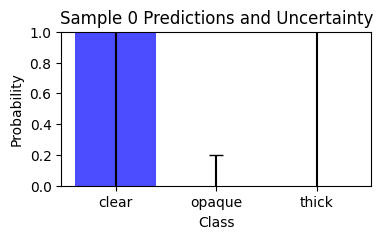

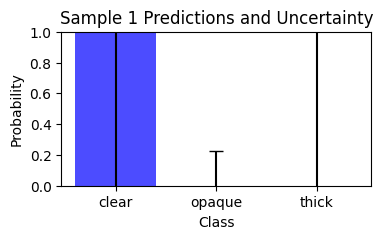

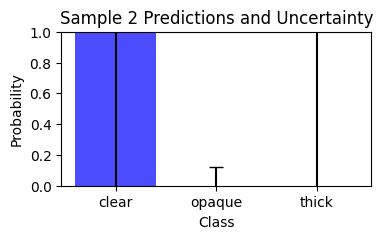

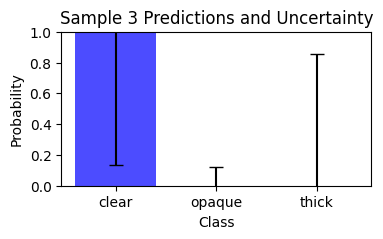

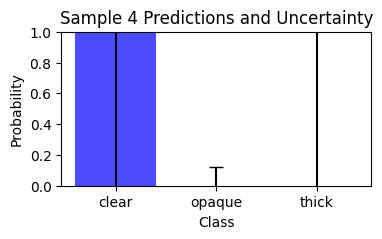

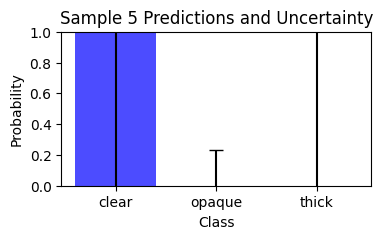

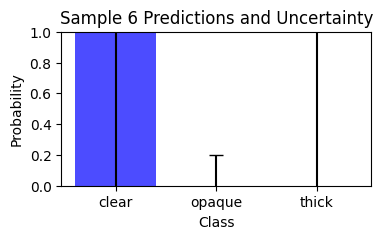

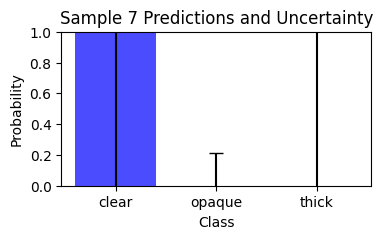

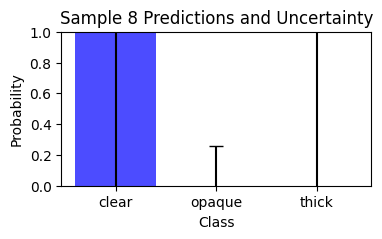

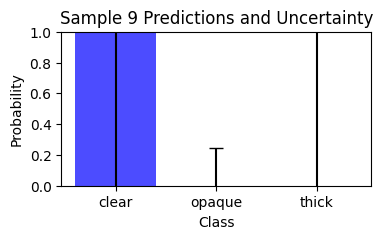

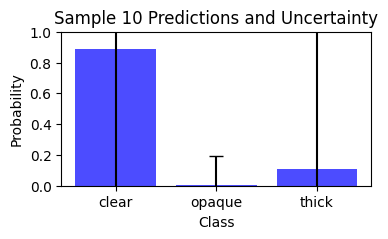

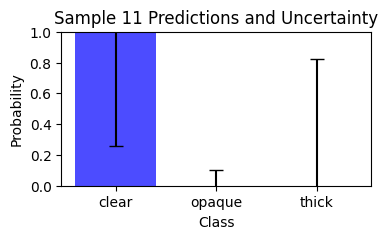

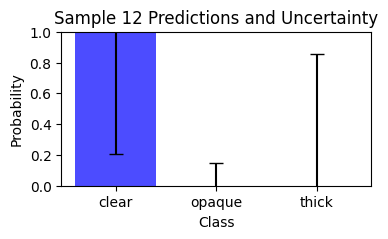

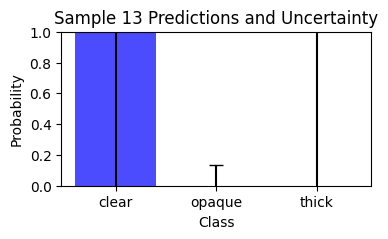

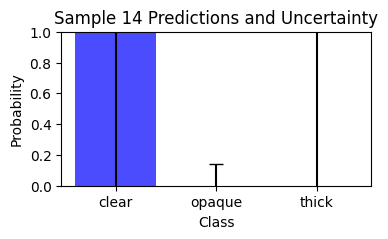

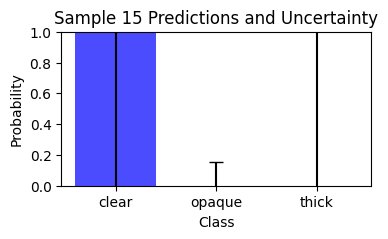

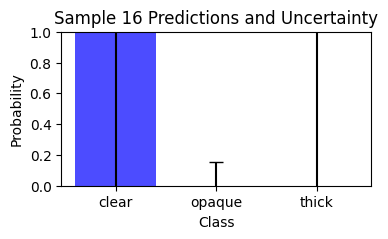

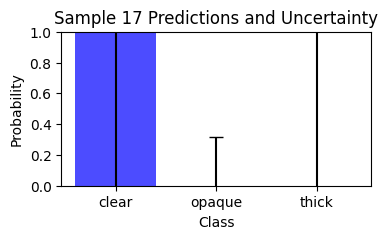

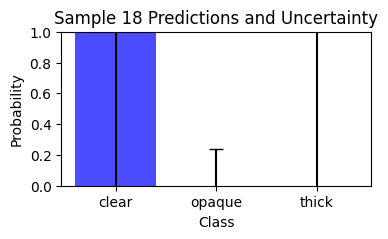

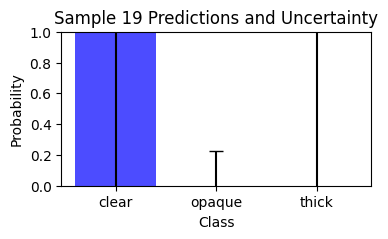

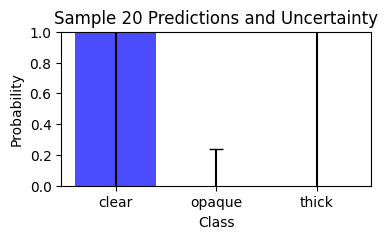

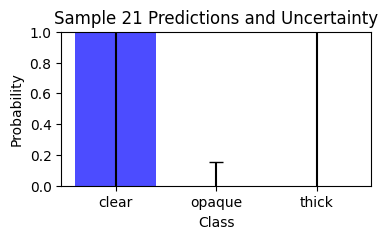

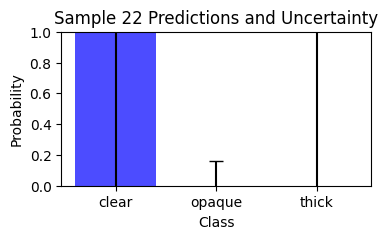

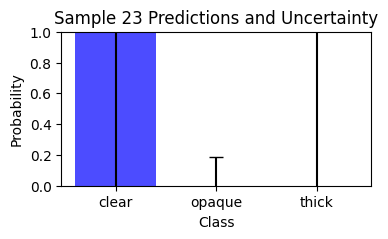

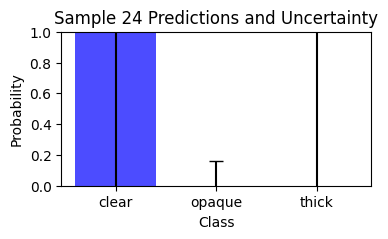

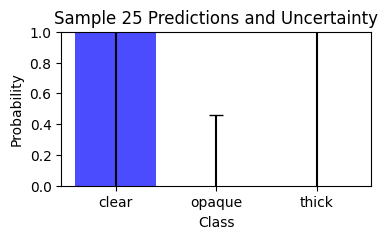

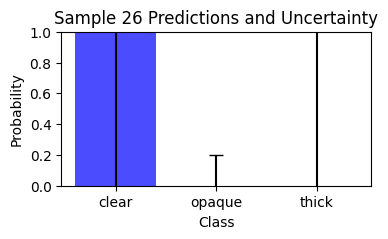

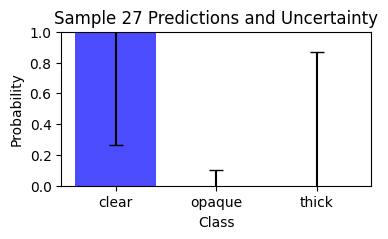

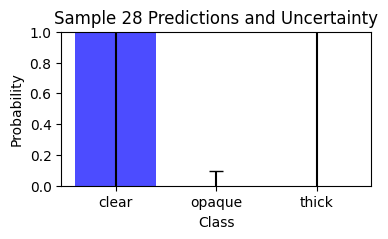

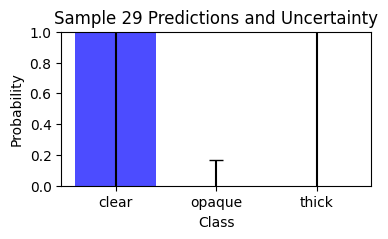

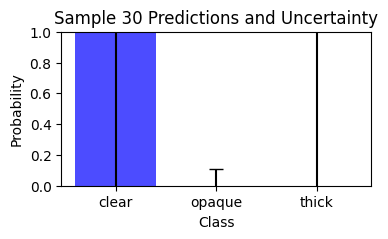

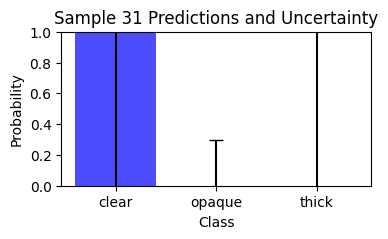

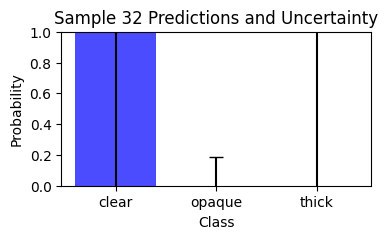

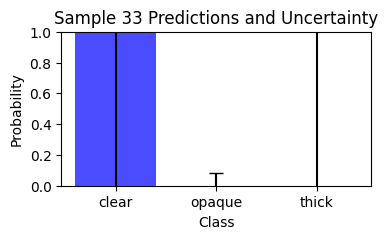

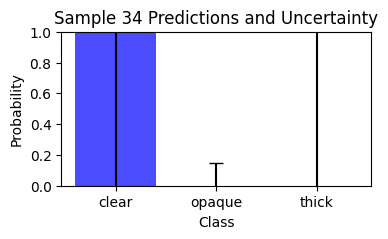

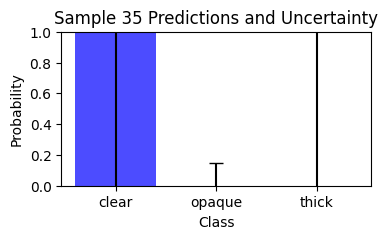

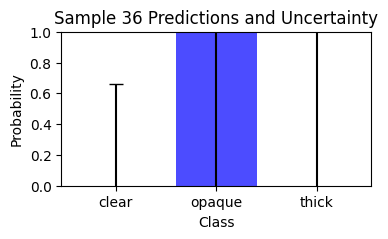

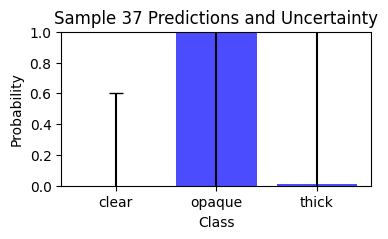

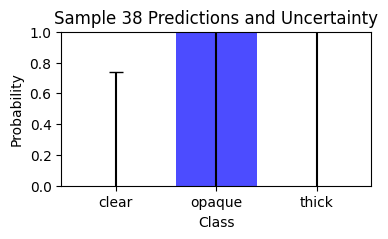

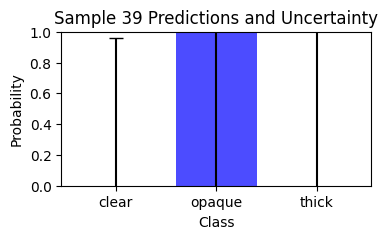

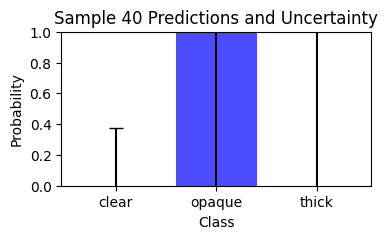

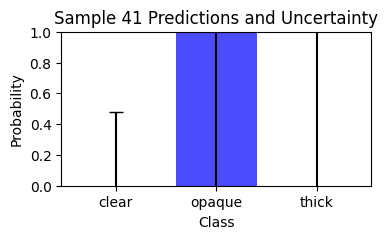

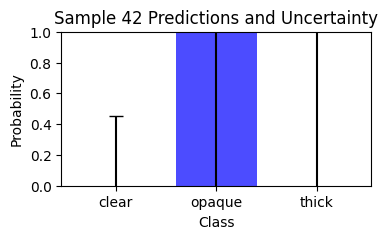

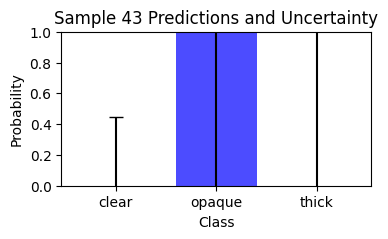

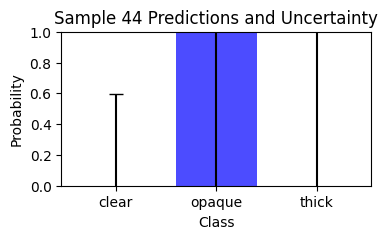

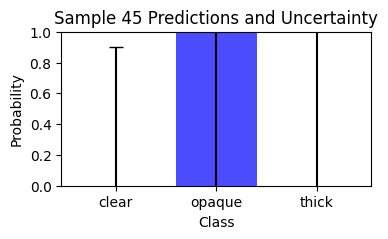

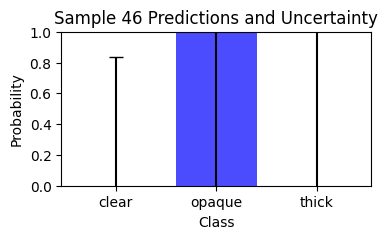

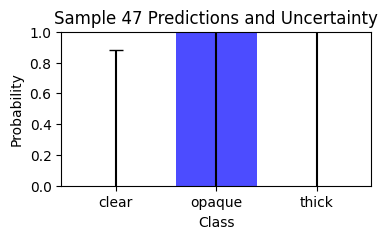

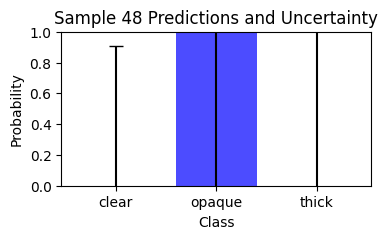

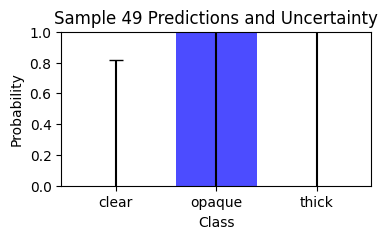

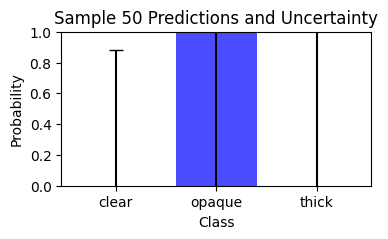

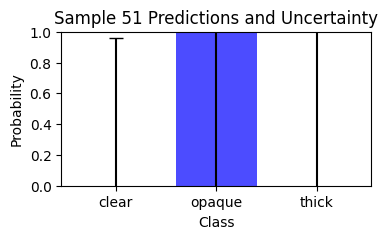

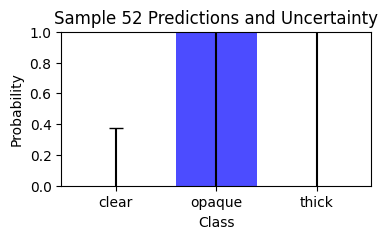

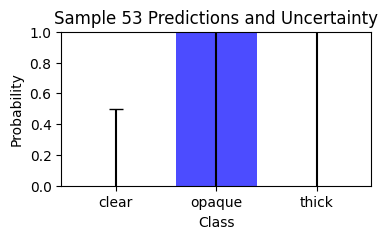

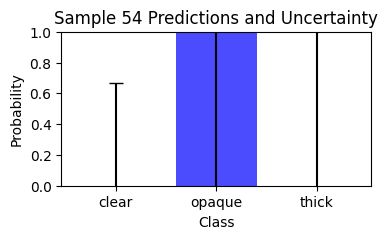

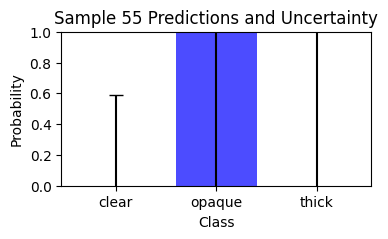

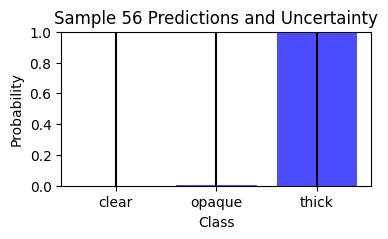

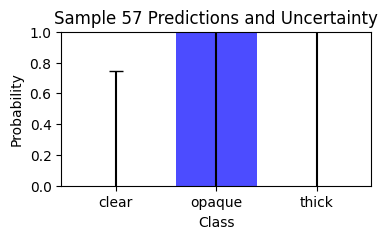

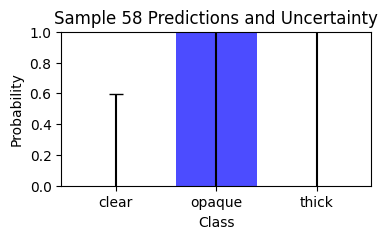

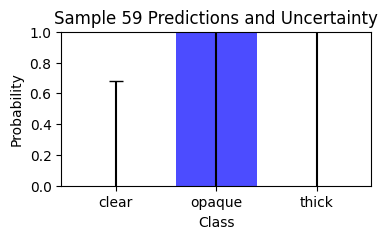

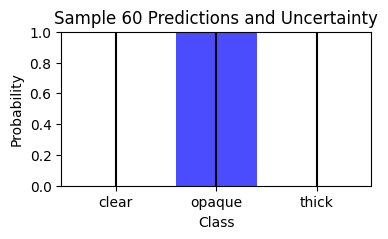

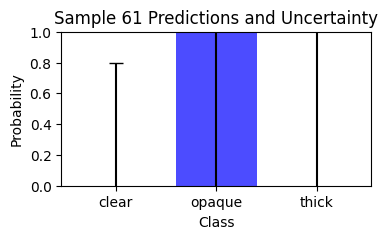

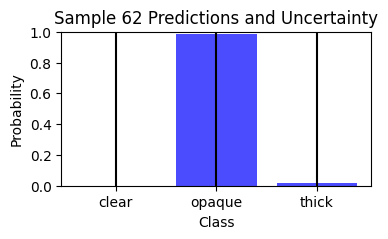

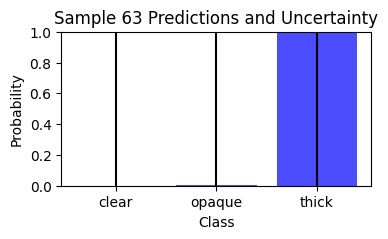

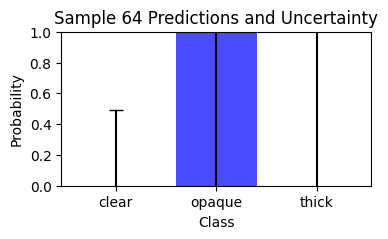

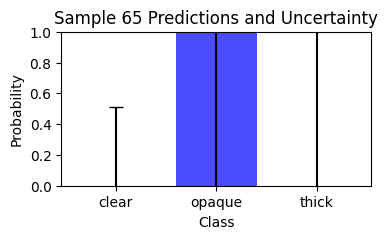

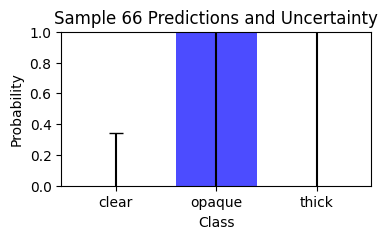

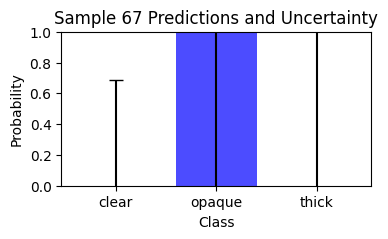

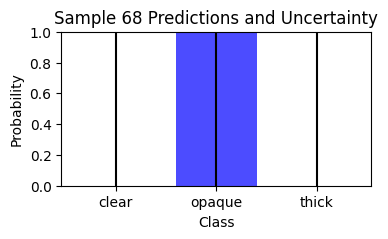

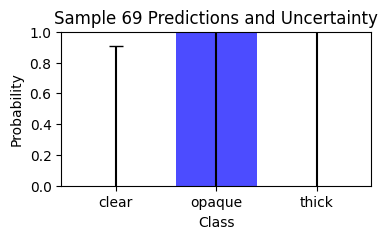

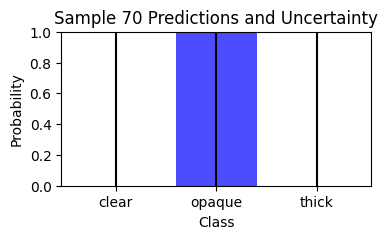

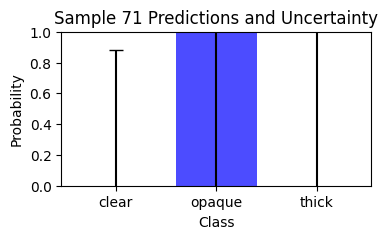

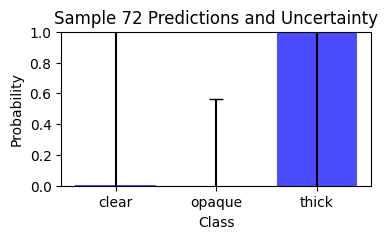

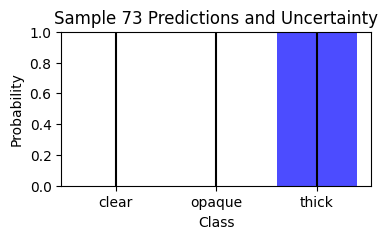

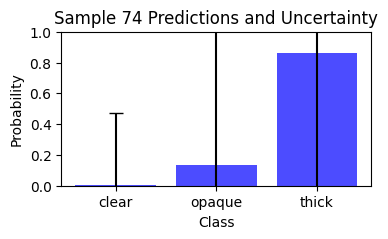

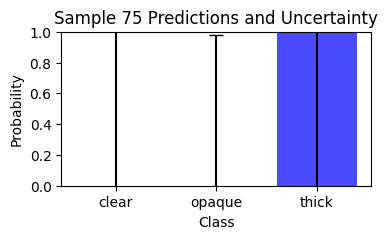

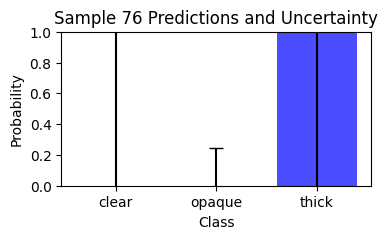

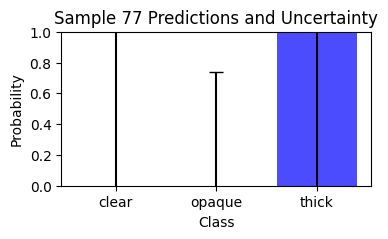

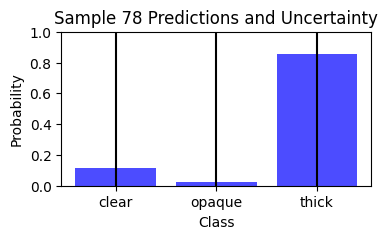

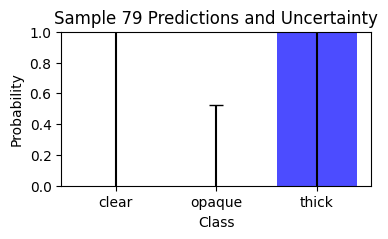

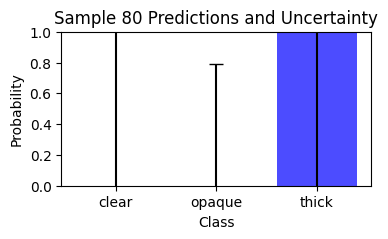

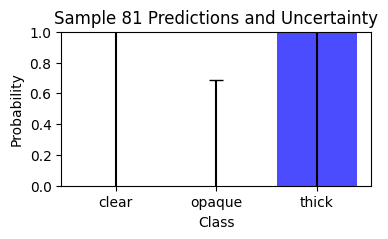

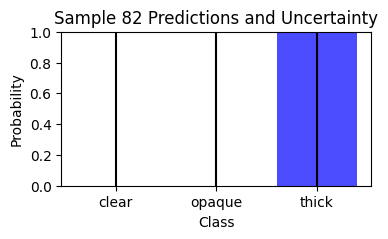

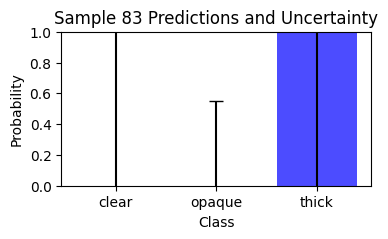

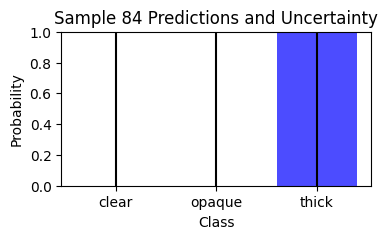

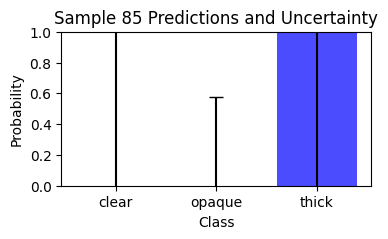

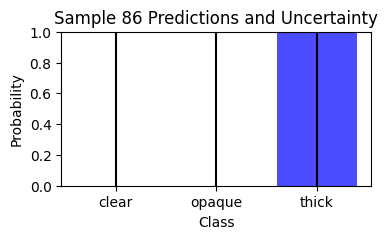

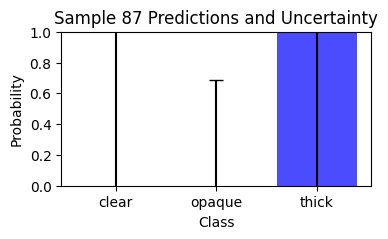

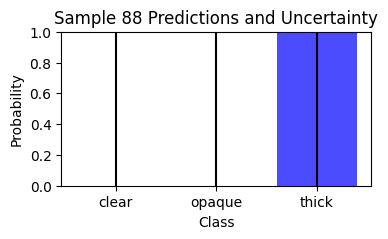

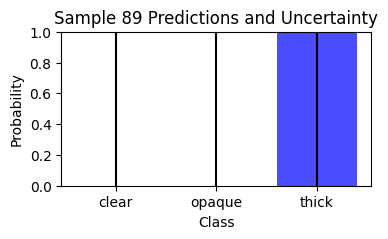

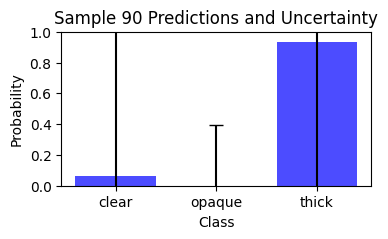

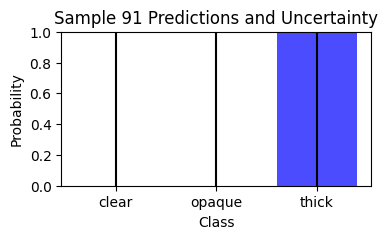

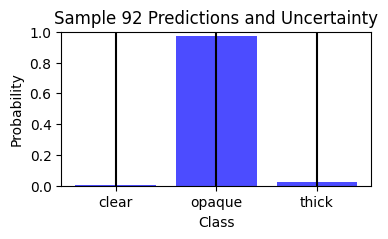

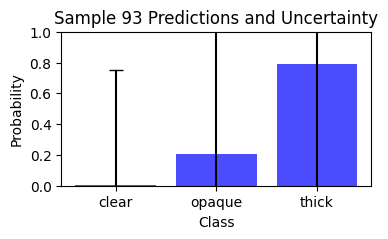

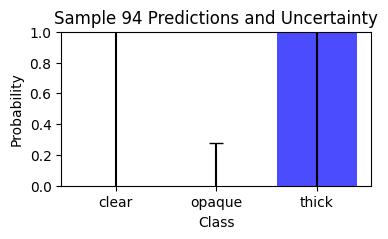

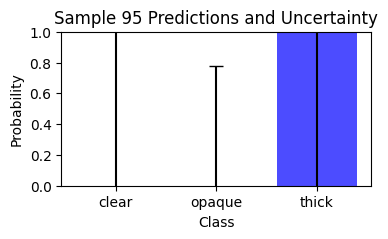

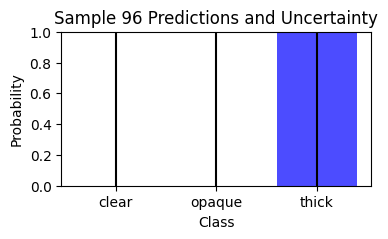

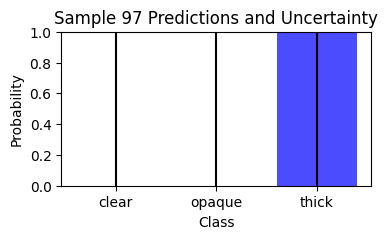

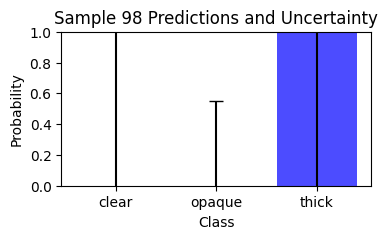

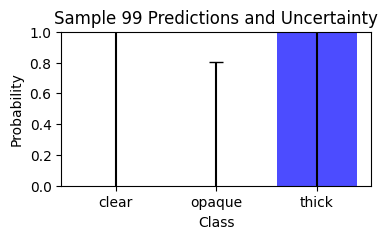

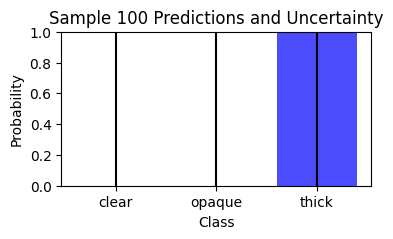

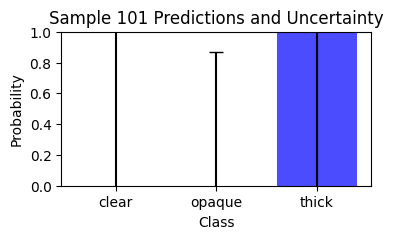

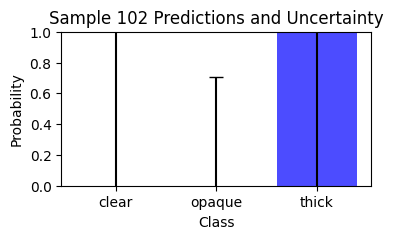

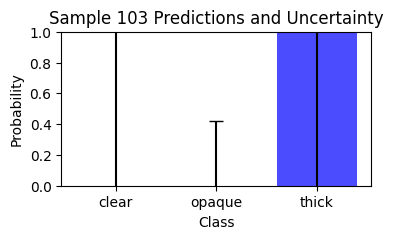

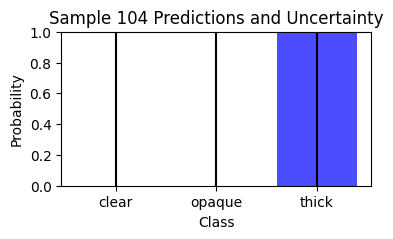

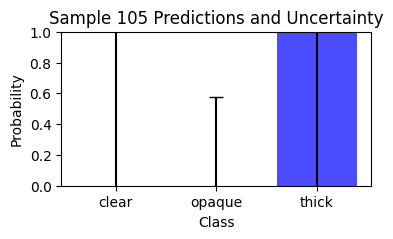

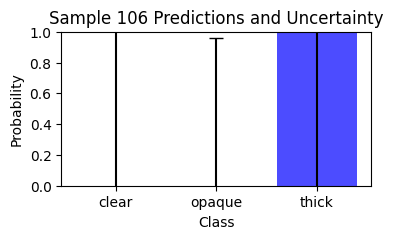

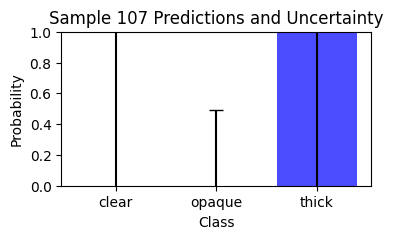

In [ ]:
for i in range(len(x_test)):
    plot_uncertainty(mean_predictions[i], prediction_variance[i], i)

###4. Visualization of class probabilities

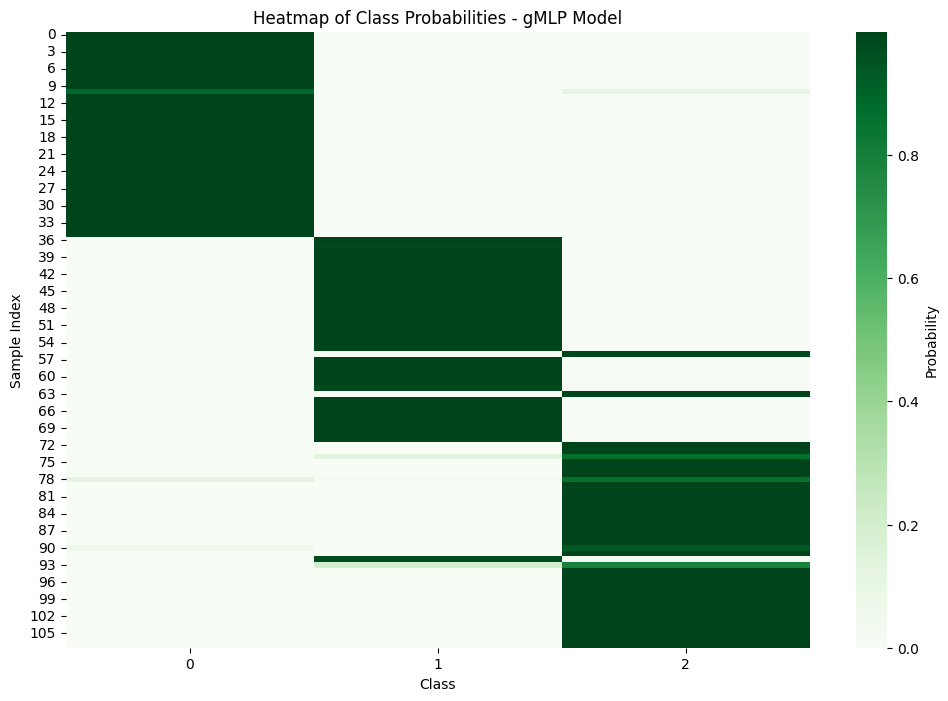

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(probabilities, cmap='Greens', cbar_kws={'label': 'Probability'}, annot=False, fmt=".2f")
plt.xlabel('Class')
plt.ylabel('Sample Index')
plt.title('Heatmap of Class Probabilities - gMLP Model')
plt.show()

###5. Variance analysis

In [ ]:
# Differences in variances for each sample
variance_differences = []
for i, variances in enumerate(prediction_variance):
    diff_0_1 = variances[1] - variances[0]  # Difference between Class 0 and Class 1
    diff_1_2 = variances[2] - variances[1]  # Difference between Class 1 and Class 2
    diff_0_2 = variances[2] - variances[0]  # Difference between Class 0 and Class 2

    variance_differences.append((diff_0_1, diff_1_2, diff_0_2))

    print(f"Sample {i}:")
    print(f"Variance differences - Class 0 to 1: {diff_0_1}, Class 1 to 2: {diff_1_2}, Class 0 to 2: {diff_0_2}")

Sample 0:
Variance differences - Class 0 to 1: -3.54933986, Class 1 to 2: 3.3828406799999997, Class 0 to 2: -0.1664991800000002
Sample 1:
Variance differences - Class 0 to 1: -2.02859477, Class 1 to 2: 2.58759281, Class 0 to 2: 0.5589980399999996
Sample 2:
Variance differences - Class 0 to 1: -0.88615153, Class 1 to 2: 0.9343801299999999, Class 0 to 2: 0.048228599999999844
Sample 3:
Variance differences - Class 0 to 1: -0.7473122200000001, Class 1 to 2: 0.7383069600000001, Class 0 to 2: -0.009005260000000015
Sample 4:
Variance differences - Class 0 to 1: -2.4638956100000002, Class 1 to 2: 2.7368501000000003, Class 0 to 2: 0.27295449000000005
Sample 5:
Variance differences - Class 0 to 1: -1.2441478000000001, Class 1 to 2: 1.24703334, Class 0 to 2: 0.0028855399999998532
Sample 6:
Variance differences - Class 0 to 1: -0.81344138, Class 1 to 2: 0.9069048, Class 0 to 2: 0.09346341999999996
Sample 7:
Variance differences - Class 0 to 1: -2.92245973, Class 1 to 2: 3.14136963, Class 0 to 2: 0

###Section 2

###1. Calculation of Expected Calibration Error (ECE)

In [ ]:
def calculate_ece(y_true, y_prob, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    ece = 0.0

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(y_true[in_bin])
            avg_confidence_in_bin = np.mean(y_prob[in_bin])
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    return ece

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

prediction_mean, _ = predict_with_uncertainty(gmlp_model, x_test, n_iter=100)
prediction_probabilities = softmax(prediction_mean)

for class_index in range(NUM_CLASSES):
    positive_class_prob = prediction_probabilities[:, class_index]
    binary_y_true = (y_test == class_index).astype(int)
    ece = calculate_ece(binary_y_true, positive_class_prob)
    print(f"Expected Calibration Error (ECE) for Class {class_index}: {ece:.4f}")

Expected Calibration Error (ECE) for Class 0: 0.0046
Expected Calibration Error (ECE) for Class 1: 0.0315
Expected Calibration Error (ECE) for Class 2: 0.0340


###2. Plotting of calibration curves

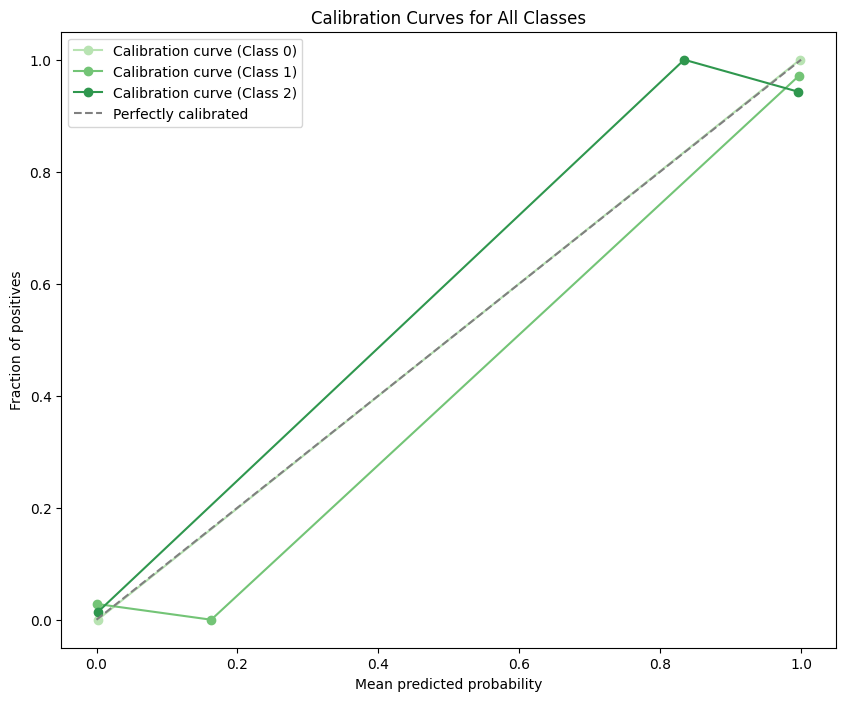

In [ ]:
def plot_calibration_curve(y_true, y_prob, class_index, color, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', label=f'Calibration curve (Class {class_index})', color=color)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

prediction_mean, _ = predict_with_uncertainty(gmlp_model, x_test, n_iter=100)
prediction_probabilities = softmax(prediction_mean)

base_color = cm.Greens
shades = [base_color(i) for i in np.linspace(0.3, 0.7, NUM_CLASSES)]

plt.figure(figsize=(10, 8))
for class_index in range(NUM_CLASSES):
    positive_class_prob = prediction_probabilities[:, class_index]
    binary_y_true = (y_test == class_index).astype(int)
    plot_calibration_curve(binary_y_true, positive_class_prob, class_index=class_index, color=shades[class_index])
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color='gray')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves for All Classes')
plt.legend()
plt.show()

###Section 3. Calculation of predictive entropy

In [ ]:
def calculate_predictive_entropy(predictive_mean):
    probabilities = np.clip(predictive_mean, 1e-10, 1.0)
    return -np.sum(probabilities * np.log(probabilities), axis=-1)

In [ ]:
prediction_mean, prediction_variance = predict_with_uncertainty(gmlp_model, x_test, n_iter=100)
predictive_entropy = calculate_predictive_entropy(prediction_mean)

for i in range(len(x_test)):
    print(f"Sample {i}:")
    print(f"  Predicted Class: {class_labels[np.argmax(prediction_mean[i])]}")
    print(f"  Predictive Entropy: {predictive_entropy[i]:.4f}")
    print()

Sample 0:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 1:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 2:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 3:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 4:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 5:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 6:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 7:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 8:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 9:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 10:
  Predicted Class: clear
  Predictive Entropy: 0.3048

Sample 11:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 12:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 13:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 14:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 15:
  Predict

###Section 4 [Not implemented as gMLP model displayed good calibration]

###Section 5

###1. Calculation of Total, Aleatoric and Epistemic Uncertainty

In [ ]:
def predict_with_uncertainty(model, x, n_iter=100):
    predictions = np.array([model(x, training=True) for _ in range(n_iter)])
    prediction_mean = np.mean(predictions, axis=0)
    prediction_variance = np.var(predictions, axis=0)
    return prediction_mean, predictions

predictions, posterior_samples = predict_with_uncertainty(gmlp_model, x_test)
epsilon = 1e-10
posterior_samples = np.clip(posterior_samples, epsilon, 1.0)

total_uncertainties = []
aleatoric_uncertainties = []
epistemic_uncertainties = []
for i in range(x_test.shape[0]):
    average_prediction = np.mean(posterior_samples[:, i, :], axis=0)
    total_uncertainty = entropy(average_prediction, axis=-1)
    aleatoric_uncertainty = np.mean([entropy(sample[i, :], axis=-1) for sample in posterior_samples], axis=0)
    epistemic_uncertainty = total_uncertainty - aleatoric_uncertainty

    total_uncertainties.append(total_uncertainty)
    aleatoric_uncertainties.append(aleatoric_uncertainty)
    epistemic_uncertainties.append(epistemic_uncertainty)

for idx, (tu, au, eu) in enumerate(zip(total_uncertainties, aleatoric_uncertainties, epistemic_uncertainties)):
    print(f"Image {idx + 1}:")
    print(f"  Total Uncertainty (TU): {tu}")
    print(f"  Aleatoric Uncertainty (AU): {au}")
    print(f"  Epistemic Uncertainty (EU): {eu}")

Image 1:
  Total Uncertainty (TU): 4.605170023097571e-09
  Aleatoric Uncertainty (AU): 4.605170023097571e-09
  Epistemic Uncertainty (EU): 0.0
Image 2:
  Total Uncertainty (TU): 4.605170023097571e-09
  Aleatoric Uncertainty (AU): 4.605170023097571e-09
  Epistemic Uncertainty (EU): 0.0
Image 3:
  Total Uncertainty (TU): 4.605170023097571e-09
  Aleatoric Uncertainty (AU): 4.605170023097571e-09
  Epistemic Uncertainty (EU): 0.0
Image 4:
  Total Uncertainty (TU): 4.605170023097571e-09
  Aleatoric Uncertainty (AU): 4.605170023097571e-09
  Epistemic Uncertainty (EU): 0.0
Image 5:
  Total Uncertainty (TU): 0.07956541329622269
  Aleatoric Uncertainty (AU): 0.013470225036144257
  Epistemic Uncertainty (EU): 0.06609518826007843
Image 6:
  Total Uncertainty (TU): 4.605170023097571e-09
  Aleatoric Uncertainty (AU): 4.605170023097571e-09
  Epistemic Uncertainty (EU): 0.0
Image 7:
  Total Uncertainty (TU): 4.605170023097571e-09
  Aleatoric Uncertainty (AU): 4.605170023097571e-09
  Epistemic Uncertai